In [1]:
import numpy as np
import pandas as pd

from scipy import stats
import math
from datetime import date, datetime

from matplotlib import pyplot as plt
import matplotlib.dates as dates

%matplotlib inline

/usr/local/lib/python3.6/dist-packages/pandas/compat/_optional.py:106: UserWarning: Pandas requires version '1.2.1' or newer of 'bottleneck' (version '1.2.0' currently installed).
  warnings.warn(msg, UserWarning)


In [2]:
def climidx_corr(climate_indices, data, col, rmean=None, ave=1, lag=None, unify=False, tmin=None, tmax=None, method ='pearson'):
    
    # check that the datetime datatypes are correct
    climate_indices['time'] = pd.DatetimeIndex(climate_indices['time'])
    data['time'] = pd.DatetimeIndex(data['time'])
    
    # add data values to climate indices to use one data frame later
    climate_indices = climate_indices.set_index(['time'])
    data = data.set_index(['time'])
    
    climate_indices['data'] = data[col]
    climate_indices.reset_index(inplace=True)
    # drop NaNs for data column
    climate_indices.dropna(subset=['data'],inplace=True)
    # sort records
    climate_indices.sort_values(by = 'time', inplace=True)
    
    # drop NaNs more more extensive if needed
    if unify == True:
        climate_indices.dropna(inplace=True)
    # in other case data is correalted with a given climate indices where both arrays are not NaN
        
    # Lag of months that data time series is leading with respect to climate indices.
    if not lag is None and lag != 0:
        if lag > 0:
            # Positive lag values indicate data time series leads climate indices
            climate_indices['data'] = np.concatenate([climate_indices['data'][lag:],lag*[np.nan]])
        else:
            #negative lag values means data lags climate indices.
            climate_indices['data'] = np.concatenate([-lag*[np.nan],climate_indices['data'][:lag]])
    
    # lower limit of year and month
    if not tmin is None:
        climate_indices = climate_indices[(climate_indices.time >= tmin)]
    if not tmax is None:
        climate_indices = climate_indices[(climate_indices.time <= tmax)]
    
    # ave is number of months to average starting of the 1st month in the dataset
    if not ave is None and ave > 0:
        climate_indices['idx'] = range(1, len(climate_indices) + 1)
        climate_indices['ave'] = [int(math.ceil(1.*idx/ave)) for idx in climate_indices['idx']]
        climate_indices = climate_indices.groupby(['ave']).mean()
    
    result = {}
    for col in climate_indices.columns.values.tolist():
        if col in ['time','year','month','data','idx','ave']:
            continue
        # drop NaNs for case when unify == False (there is no action when unify == True)
        df = climate_indices[[col,'data']].dropna()
        
        # apply running mean to time series (for both data and climate indices)
        # should be used when NaNs filtered!
        # some first and last items will be NaNs after
        if not rmean is None and rmean > 1:
            df = df.rolling(window = rmean, center = True).mean().dropna()
        
        if method == 'pearson':
            r,p = stats.pearsonr(df[col], df['data'])
        elif method == 'kendall':
            r,p = stats.stats.kendalltau(df[col], df['data'])
        elif method == 'spearman':
            r,p = stats.stats.spearmanr(df[col], df['data'])
        else:
            r,p = None,None
        result[col] = [r,p]

    return pd.DataFrame.from_dict(result, orient='index').rename(columns={0:'corr', 1:'pvalue'}).sort_values(by = 'pvalue')

### Load dataset of climate indices

In [3]:
df_cidx = pd.read_csv('/mnt/efs/data/climate_indices.csv')

### Load data file

In [4]:
df_fw = pd.read_csv('/mnt/efs/data/eccov4_spna_fw_flx.csv')
df_ht = pd.read_csv('/mnt/efs/data/eccov4_spna_heat_flx.csv')

In [5]:
def convert_time(df):
    df.time = pd.DatetimeIndex(df.time)
    df['year'], df['month'] = df['time'].dt.year, df['time'].dt.month
    df.drop(columns=['time'],inplace=True)
    df['time'] = pd.DatetimeIndex([datetime(year, month, 15) for (year,month) in zip(df.year, df.month)])
    
    return df

In [6]:
df_fw = convert_time(df_fw)
df_ht = convert_time(df_ht)

In [7]:
print(climidx_corr(df_cidx, df_fw, 'total', lag=None, ave=12, rmean=None, unify=None,
                   tmin='1993-01-15', tmax='2015-12-15', method='pearson'))

                 corr    pvalue
ssh_dtr_pc1  0.541018  0.007682
ssh_pc2      0.475648  0.021791
trend        0.469621  0.023763
trend_neg   -0.469621  0.023763
ao           0.469173  0.023915
nao_jones    0.729274  0.025775
ssh_dtr_pc2 -0.393692  0.063075
sahelrain    0.386468  0.068516
amm         -0.350954  0.100597
pacwarm     -0.396066  0.128849
moc_ht       0.311399  0.148069
tna         -0.302721  0.160308
fkl         -0.302235  0.161014
amon_sm      0.296667  0.169255
fkl_anom    -0.291562  0.177064
NTA_ersst   -0.282497  0.191536
CAR_ersst    0.278686  0.197855
nao          0.271546  0.210068
np           0.269892  0.212968
gmsst        0.249856  0.250228
aao          0.223849  0.304525
glaam       -0.218707  0.328146
tsa         -0.198613  0.363618
moc          0.192883  0.377900
atltri      -0.226678  0.398539
pdo         -0.179596  0.412228
ssh_pc1     -0.177924  0.416666
eofpac      -0.201944  0.453236
nino1        0.152248  0.487998
swmonsoon    0.174333  0.489024
brazilra

In [8]:
print(climidx_corr(df_cidx, df_ht, 'total', lag=None, ave=None, rmean=None, unify=None,
                   tmin='1993-01-15', tmax='2015-12-15', method='pearson'))

                 corr        pvalue
moc_ht      -0.616307  3.701587e-30
moc         -0.525944  5.783943e-21
ao          -0.498834  1.043999e-18
ssh_dtr_pc1 -0.442797  1.239717e-14
nao         -0.423679  2.093670e-13
ssh_pc2     -0.416381  5.881788e-13
nao_jones   -0.609047  8.733318e-12
NTA_ersst    0.327411  2.717572e-08
tna          0.321435  4.995381e-08
amm          0.280144  2.366098e-06
atltri       0.307169  1.544434e-05
pdo          0.210221  4.488716e-04
trend_neg    0.209173  4.800447e-04
trend       -0.209173  4.800447e-04
amon_us      0.189770  1.570012e-03
ssh_dtr_pc2  0.151108  1.211223e-02
amon_sm     -0.135892  2.667918e-02
espi         0.120990  4.500365e-02
meiv2        0.113666  5.977486e-02
np          -0.113540  6.005875e-02
glaam        0.114984  6.731383e-02
solar       -0.109707  6.929521e-02
fkl_anom    -0.109590  6.959466e-02
noi         -0.134184  7.839300e-02
best         0.094916  1.163250e-01
fkl         -0.086082  1.545493e-01
qbo         -0.085697  1.564

In [9]:
df_sub = df_cidx.set_index('time')[['ssh_dtr_pc1']].loc['1993-01-01':'2015-11-30']
df_sub['spgi'] = (df_sub.ssh_dtr_pc1 - df_sub.ssh_dtr_pc1.mean())/df_sub.ssh_dtr_pc1.std()
df_sub['advConv_fw'] = df_fw.set_index('time')['total']
df_sub['advConv_ht'] = df_ht.set_index('time')['total']

In [10]:
df_sub.corr()

,ssh_dtr_pc1,spgi,advConv_fw,advConv_ht
ssh_dtr_pc1,1.000000,1.000000,0.509708,-0.442797
spgi,1.000000,1.000000,0.509708,-0.442797
advConv_fw,0.509708,0.509708,1.000000,-0.690953
advConv_ht,-0.442797,-0.442797,-0.690953,1.000000


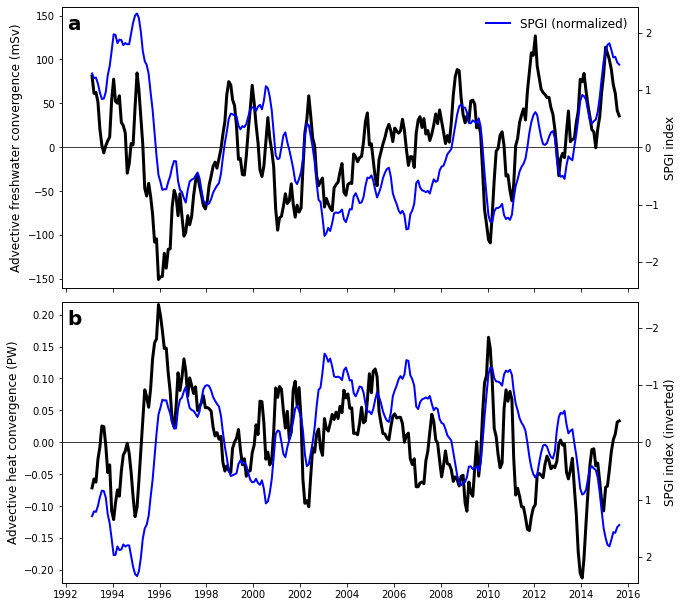

In [11]:
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(10,10))
fig.tight_layout()
fig.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, hspace=0.05)

axs[0].text(0.01,0.92, 'a', fontsize=20, fontweight='bold', transform=axs[0].transAxes)
axs[0].axhline(y=0, xmin=0, xmax=1, linewidth=0.5, color = 'k')
axs[0].plot(df_sub.index, df_sub.rolling(window=5,center=True).mean()['advConv_fw']*1e3, 
            lw=3, color='k', linestyle='-')
axs[0].set_xlim([date(1991, 11, 30), date(2016, 7, 1)])
axs[0].set_xticks(pd.date_range('1992-01-01','2018-01-01',freq='24M'))
axs[0].xaxis.set_major_formatter(dates.DateFormatter('%Y'))
axs[0].set_ylim([-160,160])
axs[0].set_ylabel(r'Advective freshwater convergence (mSv)', fontsize=12)
#ax1.invert_yaxis()

axa = axs[0].twinx()
axa.axhline(y=0, xmin=0, xmax=1, linewidth=0.5, color = 'k')
axa.plot(df_sub.index, df_sub.rolling(window=5,center=True).mean()['spgi'], lw=2, color='b',linestyle='-',
         label='SPGI (normalized)')
#axa.plot(df_sub.index, df_sub['spgi'], lw=2, color='b',linestyle='-',
#         label='SPGI (normalized)')
axa.set_xlim([date(1991, 11, 30), date(2016, 7, 1)])
axa.set_xticks(pd.date_range('1992-01-01','2018-01-01',freq='24M'))
axa.xaxis.set_major_formatter(dates.DateFormatter('%Y'))
axa.set_ylim([-2.45,2.45])
#axa.invert_yaxis()
axa.set_ylabel(r'SPGI index', fontsize=12)
axa.legend(loc='upper right',frameon=False, ncol=2, fontsize=12)

axs[1].text(0.01,0.92, 'b', fontsize=20, fontweight='bold', transform=axs[1].transAxes)
axs[1].axhline(y=0, xmin=0, xmax=1, linewidth=0.5, color = 'k')
axs[1].plot(df_sub.index, df_sub.rolling(window=5,center=True).mean()['advConv_ht'], lw=3, color='k', linestyle='-')
axs[1].set_xlim([date(1991, 11, 30), date(2016, 7, 1)])
axs[1].set_xticks(pd.date_range('1992-01-01','2018-01-01',freq='24M'))
axs[1].xaxis.set_major_formatter(dates.DateFormatter('%Y'))
axs[1].set_ylim([-0.22,0.22])
axs[1].set_ylabel(r'Advective heat convergence (PW)', fontsize=12)
#ax1.invert_yaxis()

axb = axs[1].twinx()
axb.axhline(y=0, xmin=0, xmax=1, linewidth=0.5, color = 'k')
axb.plot(df_sub.index, df_sub.rolling(window=5,center=True).mean()['spgi'], lw=2, color='b',linestyle='-',
         label='SPGI (normalized)')
axb.set_xlim([date(1991, 11, 30), date(2016, 7, 1)])
axb.set_xticks(pd.date_range('1992-01-01','2018-01-01',freq='24M'))
axb.xaxis.set_major_formatter(dates.DateFormatter('%Y'))
axb.set_ylim([-2.45,2.45])
axb.invert_yaxis()
axb.set_ylabel(r'SPGI index (inverted)', fontsize=12)
#axb.legend(loc='lower left',frameon=False, ncol=2, fontsize=12)

#plt.savefig('/mnt/efs/figure.png')
#plt.savefig('/mnt/efs/figure.eps')
#plt.savefig('/mnt/efs/figure.pdf')
plt.show()

In [12]:
df = pd.read_csv('/mnt/efs/data/convection_depth.csv').rename(columns={'Year': 'year',
                                                                       ' Max_Depth': 'max_depth', 
                                                                       ' Max_Sigma2': 'max_sigma2'})
df['max_depth'] = pd.to_numeric(df['max_depth'].astype(str).str[:-1], errors='coerce')

In [13]:
df['time'] = pd.DatetimeIndex([datetime(year, 7, 2) for year in df.year])

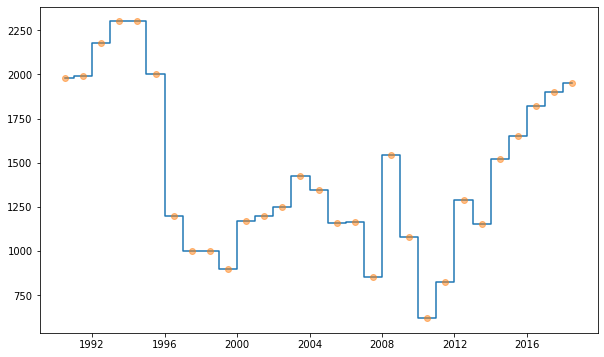

In [15]:
fig, ax = plt.subplots(figsize=(10,6))

ax.step(df.time, df.max_depth, where='mid')
ax.plot(df.time, df.max_depth, 'C1o', alpha=0.5)
plt.show()

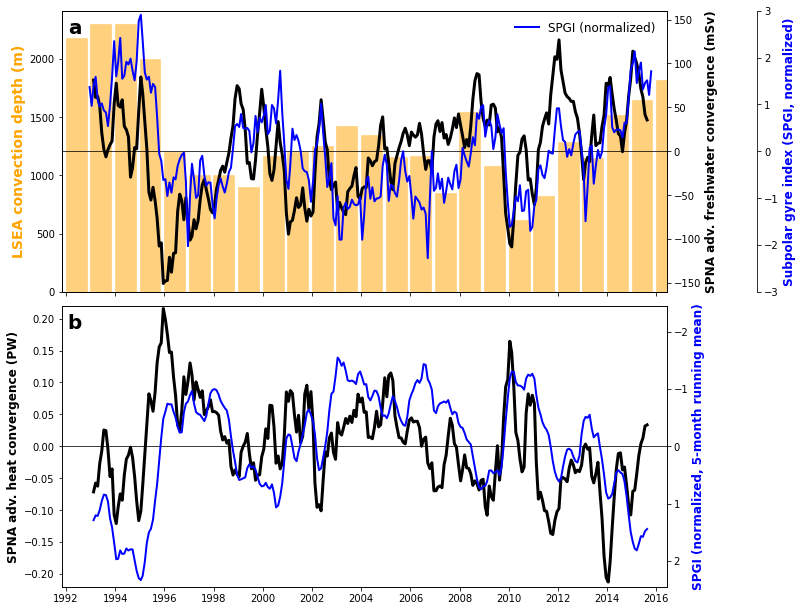

In [16]:
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(12,10))
fig.tight_layout()
fig.subplots_adjust(left=0.1, right=0.8, bottom=0.1, top=0.9, hspace=0.05)

axs[0].text(0.01,0.92, 'a', fontsize=20, fontweight='bold', transform=axs[0].transAxes)
axs[0].bar(df.time, df.max_depth,3.1e2, align='center',color='orange', edgecolor='orange', linewidth=0.5, alpha=0.5)
#axs[0].step(df.time, df.max_depth, where='mid',color='orange')
axs[0].set_xlim([date(1991, 11, 30), date(2016, 7, 1)])
axs[0].set_xticks(pd.date_range('1992-01-01','2018-01-01',freq='24M'))
axs[0].xaxis.set_major_formatter(dates.DateFormatter('%Y'))
axs[0].set_ylabel(r'LSEA convection depth (m)', fontsize=14,color='orange', fontweight='bold')
axa = axs[0].twinx()
axa.axhline(y=0, xmin=0, xmax=1, linewidth=0.5, color = 'k')
axa.plot(df_sub.index, df_sub.rolling(window=5,center=True).mean()['advConv_fw']*1e3, 
            lw=3, color='k', linestyle='-')
axa.set_xlim([date(1991, 11, 30), date(2016, 7, 1)])
axa.set_xticks(pd.date_range('1992-01-01','2018-01-01',freq='24M'))
axa.xaxis.set_major_formatter(dates.DateFormatter('%Y'))
axa.set_ylim([-160,160])
axa.set_ylabel(r'SPNA adv. freshwater convergence (mSv)', fontsize=12, fontweight='bold')
#axa.invert_yaxis()

axb = axs[0].twinx()
axb.spines['right'].set_position(('axes', 1.15))

axb.axhline(y=0, xmin=0, xmax=1, linewidth=0.5, color = 'k')
#axb.plot(df_sub.index, df_sub.rolling(window=5,center=True).mean()['spgi'], lw=2, color='b',linestyle='-',
#         label='SPGI (normalized)')
axb.plot(df_sub.index, df_sub['spgi'], lw=2, color='b',linestyle='-', label='SPGI (normalized)')
axb.set_xlim([date(1991, 11, 30), date(2016, 7, 1)])
axb.set_xticks(pd.date_range('1992-01-01','2018-01-01',freq='24M'))
axb.xaxis.set_major_formatter(dates.DateFormatter('%Y'))
axb.set_ylim([-3,3])
#axb.invert_yaxis()
axb.set_ylabel(r'Subpolar gyre index (SPGI, normalized)',fontsize=12,color='b', fontweight='bold')
axb.legend(loc='upper right',frameon=False, ncol=2, fontsize=12)

axs[1].text(0.01,0.92, 'b', fontsize=20, fontweight='bold', transform=axs[1].transAxes)
axs[1].axhline(y=0, xmin=0, xmax=1, linewidth=0.5, color = 'k')
axs[1].plot(df_sub.index, df_sub.rolling(window=5,center=True).mean()['advConv_ht'], lw=3, color='k', linestyle='-')
axs[1].set_xlim([date(1991, 11, 30), date(2016, 7, 1)])
axs[1].set_xticks(pd.date_range('1992-01-01','2018-01-01',freq='24M'))
axs[1].xaxis.set_major_formatter(dates.DateFormatter('%Y'))
axs[1].set_ylim([-0.22,0.22])
axs[1].set_ylabel(r'SPNA adv. heat convergence (PW)', fontsize=12, fontweight='bold')
#ax1.invert_yaxis()

axc = axs[1].twinx()
axc.axhline(y=0, xmin=0, xmax=1, linewidth=0.5, color = 'k')
axc.plot(df_sub.index, df_sub.rolling(window=5,center=True).mean()['spgi'], lw=2, color='b',linestyle='-',
         label='SPGI (normalized)')
axc.set_xlim([date(1991, 11, 30), date(2016, 7, 1)])
axc.set_xticks(pd.date_range('1992-01-01','2018-01-01',freq='24M'))
axc.xaxis.set_major_formatter(dates.DateFormatter('%Y'))
axc.set_ylim([-2.45,2.45])
axc.invert_yaxis()
axc.set_ylabel(r'SPGI (normalized, 5-month running mean)',fontsize=12,color='b', fontweight='bold')
#axc.legend(loc='lower left',frameon=False, ncol=2, fontsize=12)

#plt.savefig('/mnt/efs/figure.png')
#plt.savefig('/mnt/efs/figure.eps')
plt.savefig('/mnt/efs/figure.pdf')
plt.show()

In [17]:
df_sub.corr()

,ssh_dtr_pc1,spgi,advConv_fw,advConv_ht
ssh_dtr_pc1,1.000000,1.000000,0.509708,-0.442797
spgi,1.000000,1.000000,0.509708,-0.442797
advConv_fw,0.509708,0.509708,1.000000,-0.690953
advConv_ht,-0.442797,-0.442797,-0.690953,1.000000


In [18]:
df_sub = df_cidx.set_index('time')[['moc_ht']].loc['1993-01-01':'2015-11-30']
df_sub['advConv_ht'] = df_ht.set_index('time')['total']

In [9]:
df_sub = df_cidx.set_index('time')[['moc_ht']].loc['1993-01-01':'2015-11-30']
df_sub['advConv_ht'] = df_ht.set_index('time')['total']

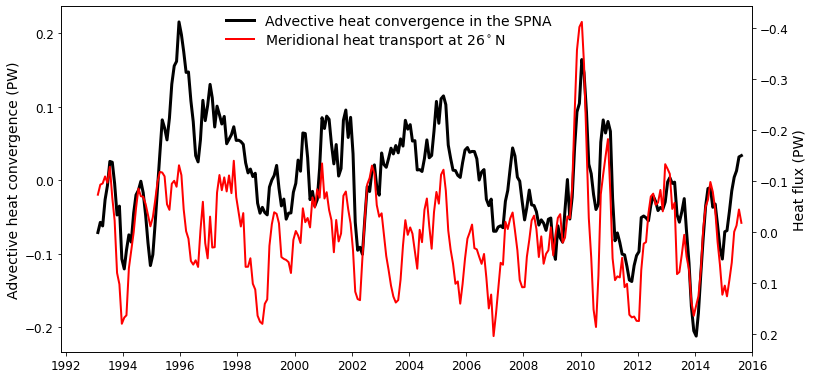

In [19]:
fig, ax1 = plt.subplots(figsize=(12,6))
fig.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9)

ax1.plot(df_sub.index, df_sub.rolling(window=5,center=True).mean()['advConv_ht'], 
         lw=3, color='k', linestyle='-',label='Advective heat convergence in the SPNA')
ax1.set_xlim([date(1991, 12, 1), date(2016, 2, 1)])
ax1.set_xticks(pd.date_range('1992-01-01','2018-01-01',freq='24M'))
ax1.xaxis.set_major_formatter(dates.DateFormatter('%Y'))
#ax1.set_ylim([-6.5e4,6.5e4])
ax1.tick_params(axis='both',labelsize=12)
ax1.set_ylabel('Advective heat convergence (PW)', color='k',fontsize=14)
ax1.legend(loc='lower left',frameon=False, bbox_to_anchor=(0.22, 0.90), fontsize=14)

ax2 = ax1.twinx()
ax2.plot(df_sub.index, df_sub.rolling(window=5,center=True).mean()['moc_ht'], lw=2, color='r',linestyle='-',
         label='Meridional heat transport at 26$^\circ$N')
ax2.set_xlim([date(1991, 12, 1), date(2016, 2, 1)])
ax2.set_xticks(pd.date_range('1992-01-01','2018-01-01',freq='24M'))
ax2.xaxis.set_major_formatter(dates.DateFormatter('%Y'))
#ax2.set_ylim([0.1,1.45])
ax2.tick_params(axis='both',labelsize=12)
ax2.invert_yaxis()

ax2.set_ylabel(r'Heat flux (PW)', color='k', fontsize=14)
ax2.legend(loc='lower left',frameon=False, bbox_to_anchor=(0.22, 0.84), fontsize=14)

#plt.savefig('/mnt/efs/figure.png')
#plt.savefig('/mnt/efs/figure.eps')
#plt.savefig('/mnt/efs/figure.pdf')
plt.show()

In [20]:
df_sub['advConv_fw'] = df_fw.set_index('time')['total'].rolling(window=5,center=True).mean()
df_sub['advConv_ht'] = df_ht.set_index('time')['total'].rolling(window=5,center=True).mean()

In [21]:
df_sub.corr()

,moc_ht,advConv_ht,advConv_fw
moc_ht,1.000000,-0.346822,0.271396
advConv_ht,-0.346822,1.000000,-0.816645
advConv_fw,0.271396,-0.816645,1.000000
